   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
Age → Outliers: 0
Annual Income (k$) → Outliers: 2
Spending Score (1-100) → Outliers: 0


C:\Users\Haani\AppData\Local\Temp\ipykernel_27768\969746847.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = np.clip(X[col], lower, upper)
C:\Users\Haani\AppData\Local\Temp\ipykernel_27768\969746847.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = np.clip(X[col], lower, upper)
C:\Users\Haani\AppData\Local\Temp\ipykernel_27768\969746847.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

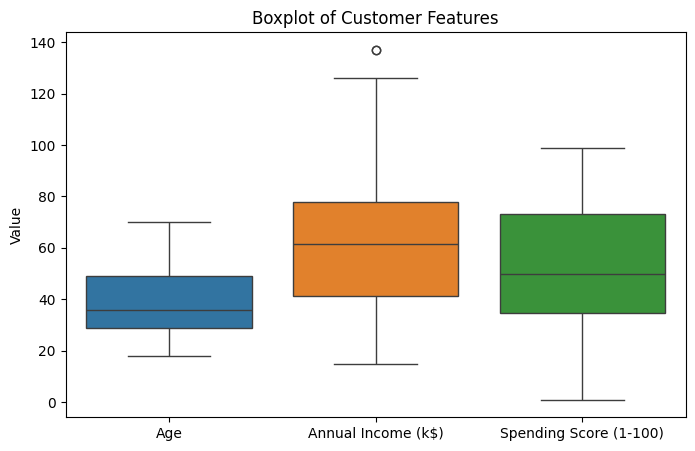

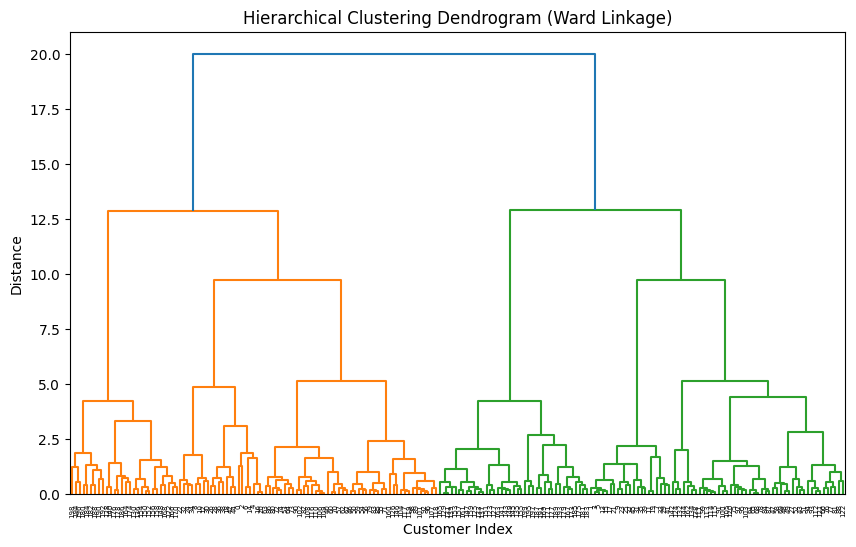

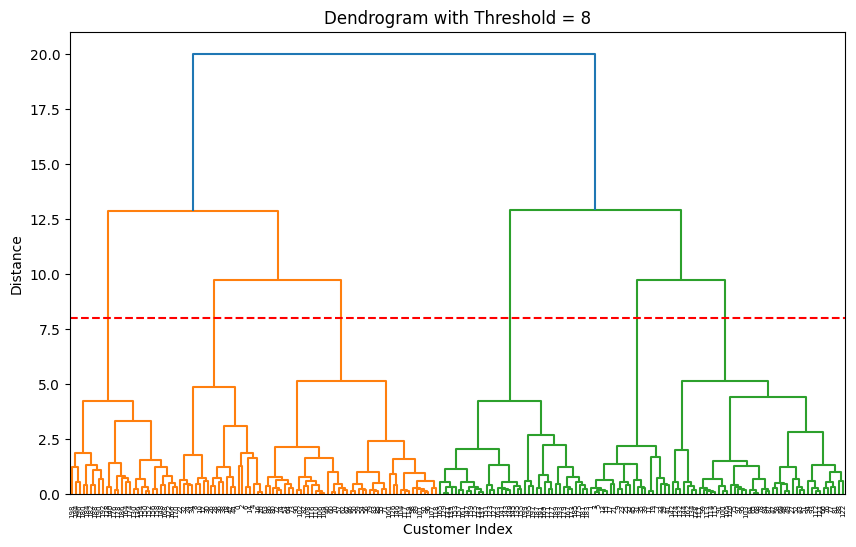

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

# -------------------------------------------------
# 1. LOAD DATA
# -------------------------------------------------

df = pd.read_csv("ML470_S7_MallCustomers_Data_Concept.csv")
print(df.head())

# select required features
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]


# -------------------------------------------------
# 2. OUTLIER DETECTION USING IQR
# -------------------------------------------------

for col in X.columns:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = ((X[col] < lower) | (X[col] > upper)).sum()
    print(f"{col} → Outliers: {outliers}")

    # Winsorization (outlier treatment)
    X[col] = np.clip(X[col], lower, upper)


# -------------------------------------------------
# 3. FEATURE SCALING
# -------------------------------------------------

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

plt.figure(figsize=(8,5))
sns.boxplot(
    data=df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
)

plt.title("Boxplot of Customer Features")
plt.ylabel("Value")
plt.show()

# -------------------------------------------------
# 4. DENDROGRAM (WARD LINKAGE)
# -------------------------------------------------

linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(10,6))
dendrogram(linked)
plt.title("Hierarchical Clustering Dendrogram (Ward Linkage)")
plt.xlabel("Customer Index")
plt.ylabel("Distance")
plt.show()


# -------------------------------------------------
# 5. DENDROGRAM WITH THRESHOLD LINE
# -------------------------------------------------

plt.figure(figsize=(10,6))
dendrogram(linked)
plt.axhline(y=8, color='r', linestyle='--')
plt.title("Dendrogram with Threshold = 8")
plt.xlabel("Customer Index")
plt.ylabel("Distance")
plt.show()


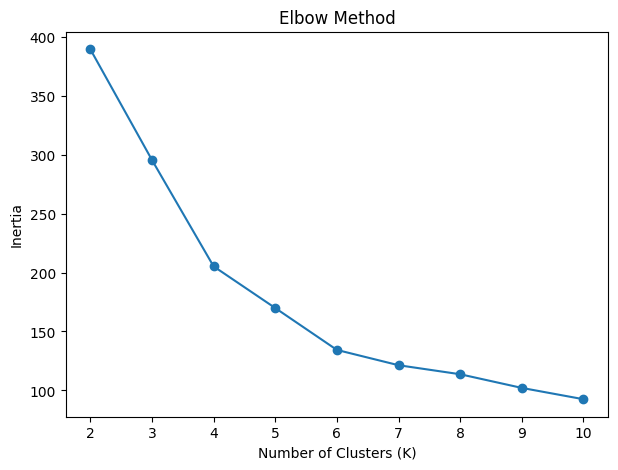

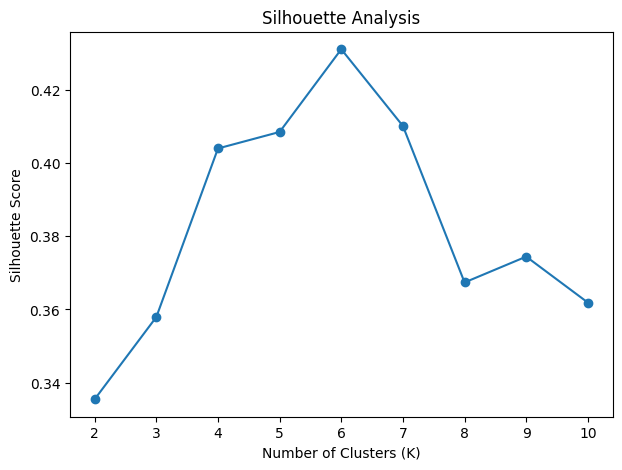

K = 2 → Silhouette Score = 0.335
K = 3 → Silhouette Score = 0.358
K = 4 → Silhouette Score = 0.404
K = 5 → Silhouette Score = 0.408
K = 6 → Silhouette Score = 0.431
K = 7 → Silhouette Score = 0.41
K = 8 → Silhouette Score = 0.367
K = 9 → Silhouette Score = 0.374
K = 10 → Silhouette Score = 0.362


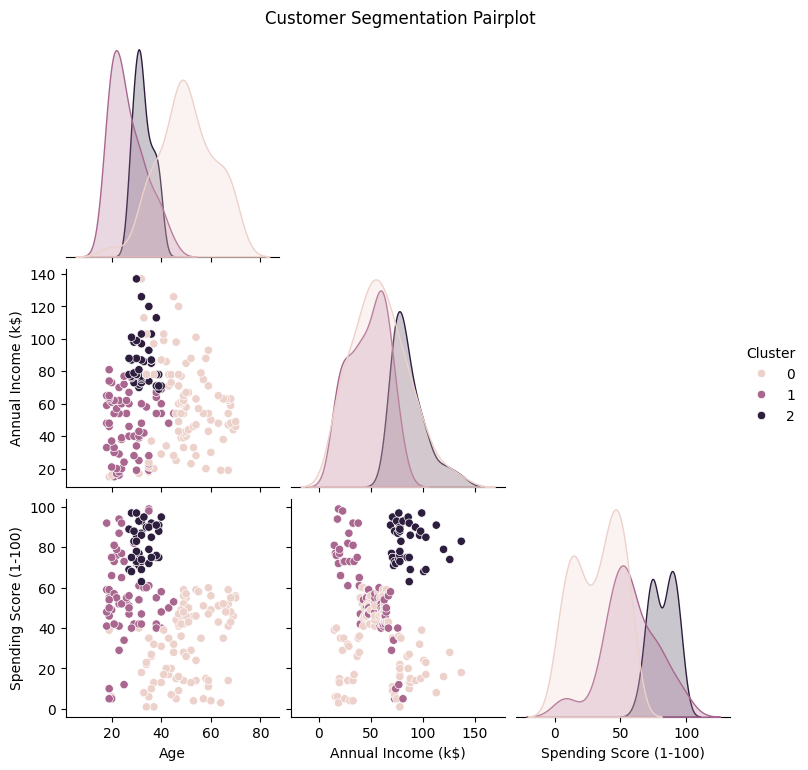

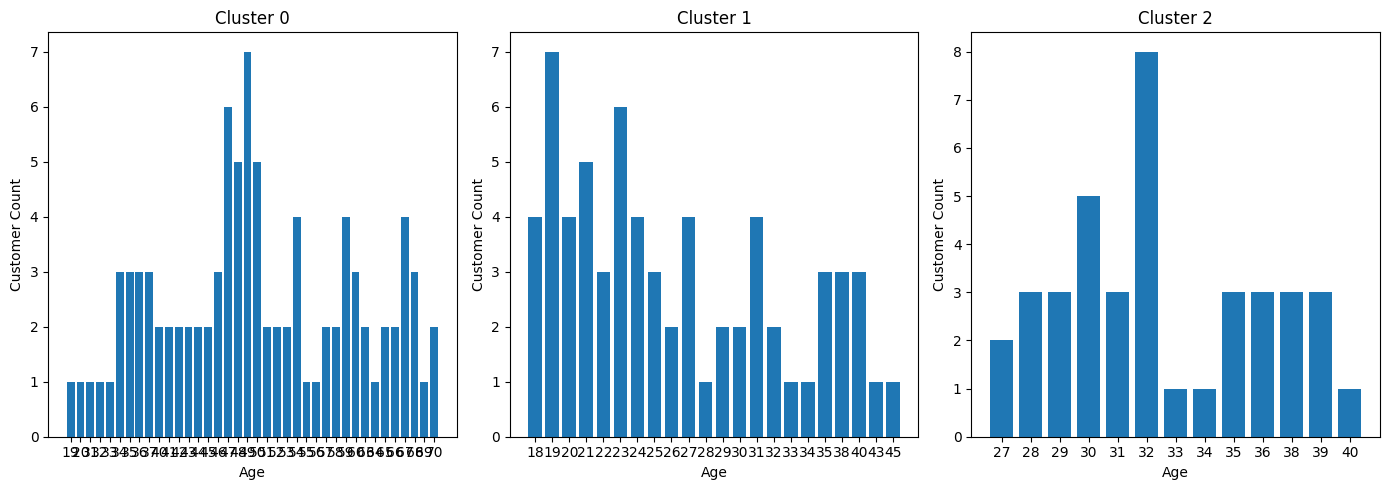

In [11]:
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7,5))
plt.plot(K, inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


# -------------------------------------------------
# 2. SILHOUETTE SCORE
# -------------------------------------------------

sil_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled)
    sil_scores.append(silhouette_score(df_scaled, labels))

plt.figure(figsize=(7,5))
plt.plot(K, sil_scores, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()

for k, s in zip(K, sil_scores):
    print(f"K = {k} → Silhouette Score = {round(s,3)}")


# -------------------------------------------------
# 3. AGGLOMERATIVE CLUSTERING
# -------------------------------------------------

agg = AgglomerativeClustering(
    n_clusters=3,
    linkage='ward'
)

df['Cluster'] = agg.fit_predict(df_scaled)


# -------------------------------------------------
# 4. PAIRPLOT
# -------------------------------------------------

sns.pairplot(
    df,
    vars=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'],
    hue='Cluster',
    corner=True
)
plt.suptitle("Customer Segmentation Pairplot", y=1.02)
plt.show()


# -------------------------------------------------
# 5. CLUSTER-WISE BAR CHARTS
# -------------------------------------------------

clusters = sorted(df['Cluster'].unique())

fig, axes = plt.subplots(1, len(clusters), figsize=(14,5))

for i, c in enumerate(clusters):
    cluster_data = df[df['Cluster'] == c]
    age_counts = cluster_data['Age'].value_counts().sort_index()

    axes[i].bar(age_counts.index.astype(str), age_counts.values)
    axes[i].set_title(f"Cluster {c}")
    axes[i].set_xlabel("Age")
    axes[i].set_ylabel("Customer Count")

plt.tight_layout()
plt.show()
